In [1]:
import os, sys

import pymongo as pm
import numpy as np
import scipy.stats as stats
import pandas as pd
import json
import re
from io import BytesIO
from PIL import Image
# from skimage import io, img_as_float
import base64

import matplotlib
from matplotlib import pylab, mlab, pyplot
%matplotlib inline
from IPython.core.pylabtools import figsize, getfigs
plt = pyplot
import seaborn as sns
sns.set_context('talk')
sns.set_style('white')

from IPython.display import clear_output
import importlib

from IPython.core.display import HTML

import analysis_utils as utils

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

### load in data

In [2]:
df = pd.read_csv (r'../results/csv/causaldraw_intervention_processed_data_2AFC.csv')

In [ ]:
df.keys()

In [3]:
check = df.loc[df['sketchID'] == 'gears_1.0219-e77f751a-a934-4602-97a0-f2c0bd8bd638']
check

,Unnamed: 0,gameID,sketchID,numBackground,numCausal,numFunctional,numSymbol,totalStrokes,propCausal,propFunctional,...,timeAnnotationPresented,timeMachinePresented,time_elapsed,toy_id,trialNum,trial_type,corr_roi,causal_roi,legend,corrAns
706,707,5896-87c62af4-06af-48e4-96e0-a6cebc7f0aa4,gears_1.0219-e77f751a-a934-4602-97a0-f2c0bd8bd638,0,4,0,7,11,0.363636,0.0,...,1610326308609,1610326302602,313253,gears_1,5,image-keyboard-response,0,noncausal,0,0
731,732,6130-1251bd4d-4eff-4d9d-9c0e-452e9dd7ad7c,gears_1.0219-e77f751a-a934-4602-97a0-f2c0bd8bd638,0,4,0,7,11,0.363636,0.0,...,1610482051148,1610482045136,305899,gears_1,2,image-keyboard-response,0,causal,0,1
977,978,8336-fafaf0c7-2d88-4682-8783-1abb640e337a,gears_1.0219-e77f751a-a934-4602-97a0-f2c0bd8bd638,0,4,0,7,11,0.363636,0.0,...,1611303405628,1611303399624,387315,gears_1,2,image-keyboard-response,0,causal,0,1
1030,1031,8793-e5dff590-6bd6-43fd-95ab-ad671ee62ff8,gears_1.0219-e77f751a-a934-4602-97a0-f2c0bd8bd638,0,4,0,7,11,0.363636,0.0,...,1611102961592,1611102955585,266554,gears_1,5,image-keyboard-response,0,noncausal,0,0
1175,1176,1146-53513ced-dcda-4b75-93f3-35f5f0561108,gears_1.0219-e77f751a-a934-4602-97a0-f2c0bd8bd638,0,4,0,7,11,0.363636,0.0,...,1608532377110,1608532371086,695242,gears_1,0,image-keyboard-response,0,noncausal,0,0
1176,1177,9628-e586d2e6-cc4a-439c-a3af-44d744594434,gears_1.0219-e77f751a-a934-4602-97a0-f2c0bd8bd638,0,4,0,7,11,0.363636,0.0,...,1609279947588,1609279941584,325500,gears_1,1,image-keyboard-response,0,noncausal,0,0


In [ ]:
df.head()

### Basic descriptive stats (e.g., how many intervention trials per sketch?)

Text(0, 0.5, 'counts')

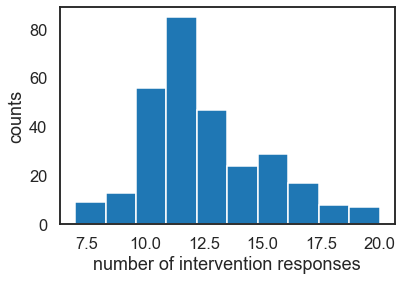

In [3]:
counts = df.sketchID.value_counts().to_dict().values()
h = plt.hist(counts)
plt.xlabel('number of intervention responses')
plt.ylabel('counts')

Text(0, 0.5, 'counts')

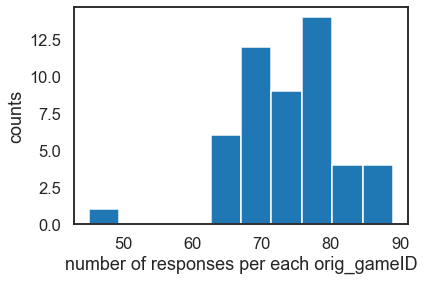

In [4]:
counts = df.orig_gameID.value_counts().to_dict().values()
h = plt.hist(counts)
plt.xlabel('number of responses per each orig_gameID')
plt.ylabel('counts')

In [5]:
## exactly how many drawings do we have how many annotations for?
from collections import Counter
Counter(Counter(df.sketchID.value_counts().to_dict()).values())

Counter({20: 1,
         19: 6,
         18: 8,
         17: 17,
         16: 12,
         15: 17,
         14: 24,
         13: 47,
         12: 55,
         11: 30,
         10: 56,
         9: 13,
         8: 3,
         7: 6})

In [6]:
## FYI: "pilot6" = collected on Prolific, "pilot7": collected on SONA during first week or so of Winter 2021 quarter
## TODO: add this metadata to the README (https://github.com/cogtoolslab/causaldraw_intervention/tree/master/intervention/README.md)
Counter(df.iterationName.values)

Counter({'pilot11': 1578,
         'pilot8': 972,
         'pilot7': 203,
         'pilot9': 344,
         'pilot10': 12,
         'pilot6': 585})

In [7]:
## number of unique sketchIDs represented in our dataset
print('We have {} unique sketch IDs represented in this dataset.'.format(df.sketchID.nunique()))

We have 295 unique sketch IDs represented in this dataset.


### Basic task performance variables (e.g., accuracy / RT)

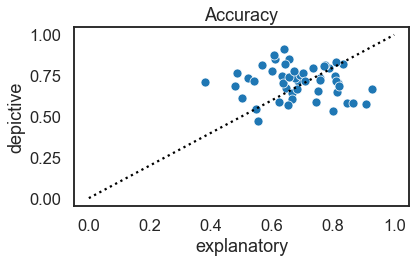

In [8]:
##### plot individual sketcher variation in intervention accuracy by condition 
##### in other words, how well did each participant's explanations vs. depictions do on this intervention test?
d = df.groupby(['orig_gameID','condition'])['corrAns'].mean().reset_index()
p = d.pivot(values='corrAns',columns='condition',index='orig_gameID').reset_index()

sns.scatterplot(data=p, 
                x='explanatory',
                y='depictive')

bound = 1
plt.plot((0,bound),(0,bound),'k:')

plt.title('Accuracy')
plt.tight_layout()

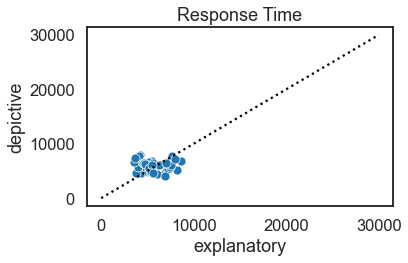

In [9]:
##### plot individual variation in RT by condition
d = df.groupby(['orig_gameID','condition'])['rt_annotationToKeyResponse'].mean().reset_index()
p = d.pivot(values='rt_annotationToKeyResponse',columns='condition',index='orig_gameID').reset_index()

sns.scatterplot(data=p, 
                x='explanatory',
                y='depictive')

bound = 30000
plt.plot((0,bound),(0,bound),'k:')

plt.title('Response Time')
plt.tight_layout()

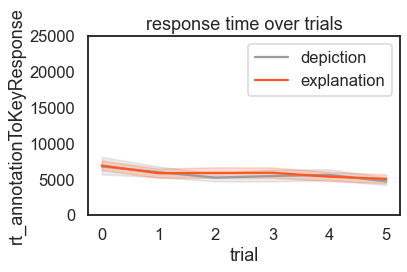

In [10]:
## across trial number
sns.lineplot(data=df, 
            x='trialNum',
            y='rt_annotationToKeyResponse',
            hue='condition', 
            palette=sns.color_palette(['#9B9B9B', '#FF5720'])
            )

L=plt.legend()
L.get_texts()[0].set_text('depiction')
L.get_texts()[1].set_text('explanation')
    
plt.xlabel('trial')
plt.ylim(0,25000)
m = plt.title('response time over trials')

plt.tight_layout()

### Response time (within-subject error bars?)

In [12]:
RT = df.groupby(['orig_gameID','condition'])['rt_annotationToKeyResponse'].mean().reset_index()
wide_RT = RT.pivot(values='rt_annotationToKeyResponse',columns='condition',index='orig_gameID').reset_index()

## first remove 'between-subject variability'
#calculate subject average
wide_RT['average'] = (wide_RT['depictive'] + wide_RT['explanatory'])/2

#calculate average of subject averages
grand_average = wide_RT['average'].mean()

#new values
wide_RT['new_depictive'] = wide_RT['depictive'] - wide_RT['average'] + grand_average
wide_RT['new_explanatory'] = wide_RT['explanatory'] - wide_RT['average'] + grand_average
wide_RT['new_average'] = (wide_RT['new_depictive'] + wide_RT['new_explanatory'])/2

#calculate standard deviation
wide_RT['sd_depictive'] = wide_RT['new_depictive'].std()
wide_RT['sd_explanatory'] = wide_RT['new_explanatory'].std()

# calculate standard error = standard deviation / square root of the number of participants
wide_RT['SE_depictive'] = wide_RT['sd_depictive']/np.sqrt(len(wide_RT))
wide_RT['SE_explanatory'] = wide_RT['sd_explanatory']/np.sqrt(len(wide_RT))

#calculate confidence interval 
wide_RT['CI_depictive'] = 1.96 * wide_RT['SE_depictive']
wide_RT['CI_explanatory'] = 1.96 * wide_RT['SE_explanatory']

In [ ]:
# wide_RT.head()

### Accuracy

In [13]:
corrAns = df.groupby(['orig_gameID','condition'])['corrAns'].mean().reset_index()
wide_corrAns = corrAns.pivot(values='corrAns',columns='condition',index='orig_gameID').reset_index()

## first remove 'between-subject variability'
#calculate subject average
wide_corrAns['average'] = (wide_corrAns['depictive'] + wide_corrAns['explanatory'])/2

#calculate average of subject averages
grand_average = wide_corrAns['average'].mean()

#new values
wide_corrAns['new_depictive'] = wide_corrAns['depictive'] - wide_corrAns['average'] + grand_average
wide_corrAns['new_explanatory'] = wide_corrAns['explanatory'] - wide_corrAns['average'] + grand_average
wide_corrAns['new_average'] = (wide_corrAns['new_depictive'] + wide_corrAns['new_explanatory'])/2

#calculate standard deviation
wide_corrAns['sd_depictive'] = wide_corrAns['new_depictive'].std()
wide_corrAns['sd_explanatory'] = wide_corrAns['new_explanatory'].std()

# calculate standard error = standard deviation / square root of the number of participants
wide_corrAns['SE_depictive'] = wide_corrAns['sd_depictive']/np.sqrt(len(wide_corrAns))
wide_corrAns['SE_explanatory'] = wide_corrAns['sd_explanatory']/np.sqrt(len(wide_corrAns))

#calculate confidence interval 
wide_corrAns['CI_depictive'] = 1.96 * wide_corrAns['SE_depictive']
wide_corrAns['CI_explanatory'] = 1.96 * wide_corrAns['SE_explanatory']

In [ ]:
# wide_corrAns.head()

### Summary plots for basic task performance variables (e.g., accuracy / RT)
error bars: https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.errorbar.html

In [224]:
#change width of bars in barplot
def change_width(g, new_value) :
    for patch in g.patches :
        current_width = patch.get_width()
        diff = current_width - new_value
        patch.set_width(new_value)
        patch.set_x(patch.get_x() + diff * .5)

#### Does intervention RESPONSE TIME differ between explanatory and depictive sketches?

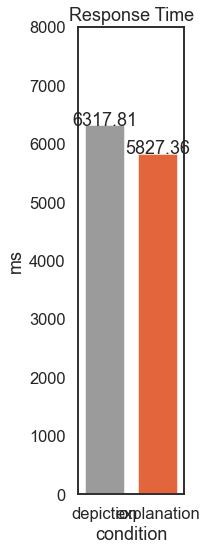

In [225]:
## RT plot
g = sns.barplot(data=df, 
            x='condition',
            y='rt_annotationToKeyResponse', 
            order=['depictive', 'explanatory'],
            palette=sns.color_palette(['#9B9B9B', '#FF5720']), 
            ci=None,
#             yerr=[wide_RT['CI_depictive'].unique()[0], wide_RT['CI_explanatory'].unique()[0]]
            )
sns.set_style("ticks")
plt.rcParams['xtick.major.size'] = 20
plt.rcParams['xtick.major.width'] = 4
plt.rcParams['xtick.bottom'] = False
plt.rcParams['ytick.left'] = True

#labels
g.set(xticklabels=["depiction", "explanation"])
l = plt.ylabel('ms')
m = plt.title('Response Time')

#plot height
plt.ylim(0, 8000)

#params for significance line
x1, x2 = 0, 1
y1, y2 = 7200, 7200
h, col = 150, 'k'

#add line
# plt.plot([x1,x1, x2, x2], [y1,y1+h, y2+h, y2], lw=1.5, c=col)
# plt.text((x1+x2)*.5, y1+h, "ns", ha='center', va='bottom', color=col)

#bar width
change_width(g, .75)

#add height of bars -- comment this out when exporting fig
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2,
            height+.18,
            '{:}'.format(height.round(2)),
            ha="center") 

#plot prettiness settings
plt.tight_layout(rect=[0, 0, .5, 2])

#save out
plt.savefig('causaldraw_intervention_RT.pdf', format='pdf', dpi=300, bbox_inches = "tight")

#### Does intervention ACCURACY differ between explanatory and depictive sketches?

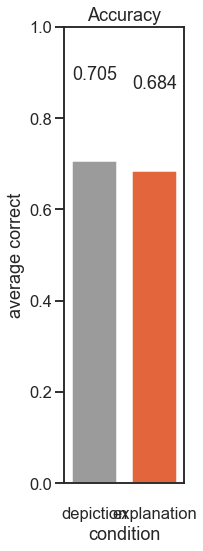

In [226]:
## corrAns plot
g = sns.barplot(data=df, 
            x='condition',
            y='corrAns', 
            order=['depictive', 'explanatory'],
            palette=sns.color_palette(['#9B9B9B', '#FF5720']), 
            ci=None,
#             yerr=[wide_corrAns['CI_depictive'].unique()[0], wide_corrAns['CI_explanatory'].unique()[0]]
            )
sns.set_style("ticks")
plt.rcParams['xtick.major.size'] = 20
plt.rcParams['xtick.major.width'] = 4
plt.rcParams['xtick.bottom'] = False
plt.rcParams['ytick.left'] = True

#labels
g.set(xticklabels=["depiction", "explanation"])
l = plt.ylabel('average correct')
m = plt.title('Accuracy')

#plot height
plt.ylim(0, 1)

#params for significance line
x1, x2 = 0, 1
y1, y2 = .85, .85
h, col = .02, 'k'

#add line
# plt.plot([x1,x1, x2, x2], [y1,y1+h, y2+h, y2], lw=1.5, c=col)
# plt.text((x1+x2)*.5, y1+h, "***", ha='center', va='bottom', color=col)

#bar width
change_width(g, .75)


#add height of bars -- comment this out when exporting fig
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2,
            height+.18,
            '{:}'.format(height.round(3)),
            ha="center") 

#plot prettiness settings
plt.tight_layout(rect=[0, 0, .5, 2])

#save out
plt.savefig('causaldraw_intervention_corrAns.pdf', format='pdf', dpi=300, bbox_inches = "tight")

#### Is there a relationship between accuracy and RT? 

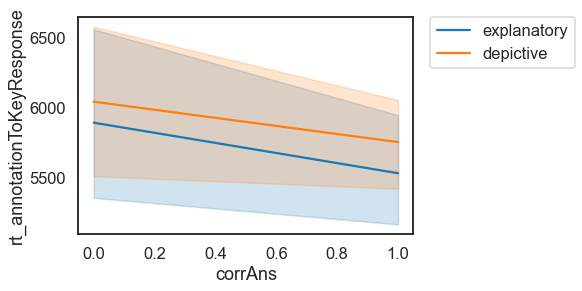

In [11]:
##### plot corrAns by rt
# Is there a relationship between accuracy and RT? 
# (Is taking longer to respond associated with higher accuracy?)
sns.lineplot(data=df, 
            x='corrAns',
            y='rt_annotationToKeyResponse',
            hue='condition'
            )

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

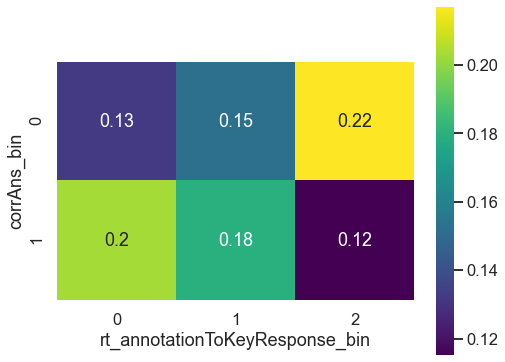

In [12]:
## compare this contingency table with the above (accuracy vs. RT)
importlib.reload(utils)
mat_normed, agg_df = utils.extract_contingency_table_from_df(df, 
                                              expUnit = 'sketchID', 
                                              xvar = 'rt_annotationToKeyResponse',
                                              yvar = 'corrAns',
                                              num_xbins = 3,
                                              num_ybins = 2,
                                              render_heatmap = True, fig_width = 8)


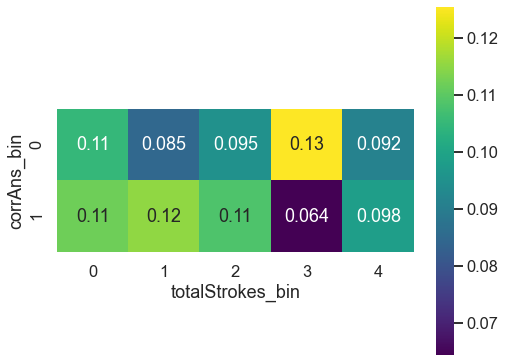

In [13]:
## another contingency table 
importlib.reload(utils)
mat_normed, agg_df = utils.extract_contingency_table_from_df(df, 
                                              expUnit = 'sketchID', 
                                              xvar = 'totalStrokes',
                                              yvar = 'corrAns',
                                              num_xbins = 5,
                                              num_ybins = 2,
                                              render_heatmap = True, 
                                              fig_width = 8,
                                              normed=True)


In [ ]:
# combined = pd.read_csv('../results/csv/combined_intervention_identification_2AFC_data.csv')
# combined.head()

#### Is there a relationship between how well a sketch supports identification & how well it supports intervention?

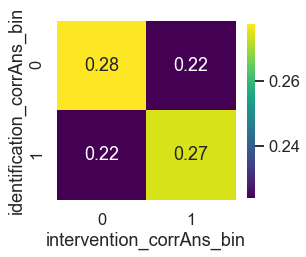

In [14]:
## load in combined data
combined = pd.read_csv('../results/csv/combined_intervention_identification_intervention_2_2AFC_data.csv')

## extract contingency table for identification task performance and intervention task performance
importlib.reload(utils)
mat_normed, sketch_df = utils.extract_contingency_table_from_df(combined, 
                                              expUnit = 'sketchID', 
                                              xvar = 'intervention_corrAns',
                                              yvar = 'identification_corrAns',
                                              num_xbins = 2,
                                              num_ybins = 2,
                                              render_heatmap = True, 
                                              fig_width = 4, fig_height = 4)

#### Using the sketches from each of the bins above: (LOW, LOW), (LOW, HIGH), (HIGH, LOW), and (HIGH, HIGH), what distinguishes them w.r.t. the kinds of strokes they contain?

In [23]:
combined.head()

In [15]:
assert sketch_df.shape[0] == combined.shape[0]
sketch_df = sketch_df.sort_values(by='sketchID')
combined = combined.sort_values(by='sketchID')

## deborkify
if 'Unnamed: 0' in combined.columns:
    combined.drop(labels=['Unnamed: 0'], inplace=True, axis=1)

## sanity check to make sure that order of sketches is same in sketch_df and combined
assert len([i for (i,j) in list(zip(sketch_df.sketchID.values, combined.sketchID.values)) if i!=j])==0

## ok, only once it passes that check, tack on the stroke semantics columns
sketch_df = sketch_df.merge(combined[['sketchID','propCausal','propFunctional','propBackground','propSymbol']])

In [16]:
## okay somewhat inelegant way of grabbing the sketches in each category
this_cond = 'explanatory'
lowID_lowIN = (sketch_df['intervention_corrAns_bin']==0) & (sketch_df['identification_corrAns_bin']==0) 
lowID_highIN = (sketch_df['intervention_corrAns_bin']==0) & (sketch_df['identification_corrAns_bin']==1)
highID_lowIN = (sketch_df['intervention_corrAns_bin']==1) & (sketch_df['identification_corrAns_bin']==0)
highID_highIN = (sketch_df['intervention_corrAns_bin']==1) & (sketch_df['identification_corrAns_bin']==1)

## make sure that these props sum to 1
assert sketch_df[lowID_lowIN][['propCausal','propFunctional','propBackground','propSymbol']].mean().round(3).sum()==1

In [17]:
sketch_df[lowID_lowIN][['propCausal','propFunctional','propBackground','propSymbol']].mean()

propCausal        0.285266
propFunctional    0.222179
propBackground    0.347969
propSymbol        0.144585
dtype: float64

In [18]:
sketch_df[lowID_highIN][['propCausal','propFunctional','propBackground','propSymbol']].mean()

propCausal        0.224053
propFunctional    0.196057
propBackground    0.495174
propSymbol        0.084716
dtype: float64

In [19]:
sketch_df[highID_lowIN][['propCausal','propFunctional','propBackground','propSymbol']].mean()

propCausal        0.319940
propFunctional    0.198547
propBackground    0.312932
propSymbol        0.168581
dtype: float64

In [20]:
sketch_df[highID_highIN][['propCausal','propFunctional','propBackground','propSymbol']].mean()

propCausal        0.268791
propFunctional    0.244897
propBackground    0.382251
propSymbol        0.104061
dtype: float64

In [ ]:
# sketch_df.head()

In [ ]:
# high = sketch_df.loc[sketch_df['intervention_corrAns'] == 1]
# len(high)

In [ ]:
# low = sketch_df.loc[sketch_df['intervention_corrAns'] == 0]
# len(low)

In [ ]:
# sketch_df.groupby('intervention_corrAns').count()

#### Logic of analysis
"Kinds of sketches"
1. "Causal-only" (causal present, functional absent, background absent)
2. "Mechanical-only" (causal present, functional present, background absent)
3. "Structural-only"(causal absent, functional absent, background present)
4. "Functional-only" (causal absent, functional present, background absent)
5. "Causal + Structural" (causal present, functional absent, background present)
6. "Functional + Structural" (causal absent, functional present, background present)
7. "ALL" (causal present, functional present, background present)
8. "None" (causal absent, functional absent, background absent)

For each of these kinds of sketches, what is the probability of being in the "higher tier" of intervention performance (above median)? OR What is the average intervention accuracy?

In [ ]:
## criteria for sketch_type (must be 2% or higher to fulfill)
# https://stackoverflow.com/questions/26886653/pandas-create-new-column-based-on-values-from-other-columns-apply-a-function-o
# thresh = 0.1

# conditions = [
#     (combined['propCausal'] > thresh) & (combined['propFunctional'] < thresh) & (combined['propBackground'] < thresh),
#     (combined['propCausal'] > thresh) & (combined['propFunctional'] > thresh) & (combined['propBackground'] < thresh),
#     (combined['propCausal'] < thresh) & (combined['propFunctional'] < thresh) & (combined['propBackground'] > thresh), 
#     (combined['propCausal'] < thresh) & (combined['propFunctional'] > thresh) & (combined['propBackground'] < thresh),
#     (combined['propCausal'] > thresh) & (combined['propFunctional'] < thresh) & (combined['propBackground'] > thresh),
#     (combined['propCausal'] < thresh) & (combined['propFunctional'] > thresh) & (combined['propBackground'] > thresh),
#     (combined['propCausal'] > thresh) & (combined['propFunctional'] > thresh) & (combined['propBackground'] > thresh), 
#     (combined['propCausal'] < thresh) & (combined['propFunctional'] < thresh) & (combined['propBackground'] < thresh)
#     ]

# ## name sketch_type
# values = [
#     'causal_only', 
#     'mechanical_only', 
#     'structural_only', 
#     'functional_only',
#     'causal_structural',
#     'functional_structural',
#     'all',
#     'none'
#     ]

# # apply to dataframe
# combined['sketch_type'] = np.select(conditions, values)

### Jan 21 2021: Judy attempt to group sketches into sketchTypes in a potentially more principled/data-driven manner

In [29]:
## NUM STUFF
## create dataframe that contains the proportion of strokes of each type
S = combined[['sketchID','numCausal','numFunctional','numBackground','numSymbol']]

## these are the names of the columns comprising the "feature vector" for this sketch
feat_cols = ['numCausal','numFunctional','numBackground','numSymbol']

## sanity check to make sure all of these proportions within sketch sum to one
S = S.assign(addToOne = S.apply(lambda x: x['numCausal'] + x['numFunctional'] + x['numBackground'] + x['numSymbol'], axis=1))
# assert np.round(S['addToOne'],3).nunique()==1

In [21]:
## PROP STUFF
## create dataframe that contains the proportion of strokes of each type
S = combined[['sketchID','propCausal','propFunctional','propBackground','propSymbol']]

## these are the names of the columns comprising the "feature vector" for this sketch
feat_cols = ['propCausal','propFunctional','propBackground','propSymbol']

## sanity check to make sure all of these proportions within sketch sum to one
S = S.assign(addToOne = S.apply(lambda x: x['propCausal'] + x['propFunctional'] + x['propBackground'] + x['propSymbol'], axis=1))
assert np.round(S['addToOne'],3).nunique()==1

Text(0.5, 1.0, 't-SNE visualization of drawings')

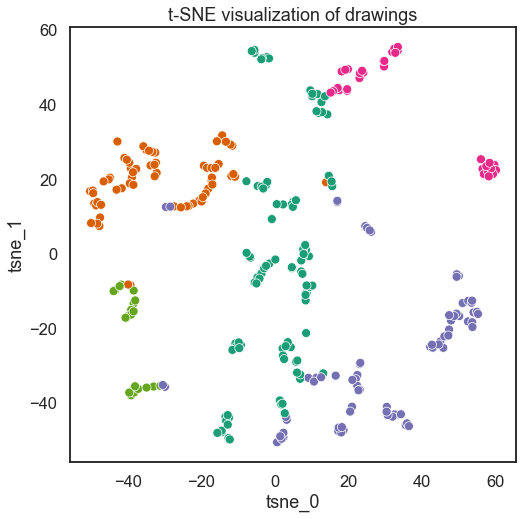

In [22]:
## apply TSNE to kinda bunch together drawings that seem more similar
from sklearn.manifold import TSNE
_S = TSNE(n_components=2,perplexity=5, random_state=0).fit_transform(S[feat_cols])
S_ = pd.DataFrame(_S)
S_.columns=['tsne_0', 'tsne_1']

## apply k-means clustering to get clusters of drawings
from sklearn.cluster import KMeans
num_clusters = 5
X = S[feat_cols]
kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(X)
S_['cluster_ind'] = kmeans.labels_

## create S2, which also contains cluster assignments
S2 = pd.concat([S,S_],axis=1)

## visualize
plt.figure(figsize=(8,8))
sns.scatterplot(data=S_, 
                x='tsne_0',
                y='tsne_1',
                hue='cluster_ind',
                palette='Dark2',
                legend=False)
plt.title('t-SNE visualization of drawings')

In [23]:
## what "kind" of sketches are in each cluster?
S2.groupby('cluster_ind')[feat_cols].mean()

,propCausal,propFunctional,propBackground,propSymbol
cluster_ind,,,,
0,0.221911,0.205249,0.549778,0.023062
1,0.213270,0.175952,0.181444,0.429334
2,0.375665,0.384931,0.215163,0.024241
3,0.048628,0.064659,0.881505,0.005208
4,0.700538,0.033151,0.097795,0.168516


In [24]:
## how many of each sketch type?
S2['cluster_ind'].value_counts()

0    98
2    76
1    68
3    32
4    21
Name: cluster_ind, dtype: int64

In [ ]:
## when we specify 5 clusters, here is what we get
# 	propCausal	propFunctional	propBackground	propSymbol
# cluster_ind				
# 0	0.211383	0.177503	0.185293	0.425821 "symbol-biased"
# 1	0.081218	0.078040	0.833475	0.007267 "background-focused"
# 2	0.392884	0.404255	0.180636	0.022225 "mechanical"
# 3	0.238704	0.232186	0.504165	0.024944 "mechanical + background mostly"
# 4	0.691815	0.034809	0.099560	0.173816 "causal-focused"

# propCausal	propFunctional	propBackground	propSymbol
# cluster_ind				
# 0	0.221911	0.205249	0.549778	0.023062 "mechanical + background mostly"
# 1	0.213270	0.175952	0.181444	0.429334 "causalish + symbol-biased"
# 2	0.375665	0.384931	0.215163	0.024241 "mechanical"
# 3	0.048628	0.064659	0.881505	0.005208 "background-focused"
# 4	0.700538	0.033151	0.097795	0.168516 "causal-focused"

## NUM STUFF

# 	numCausal	numFunctional	numBackground	numSymbol
# cluster_ind				
# 0	4.000000	4.283019	16.452830	0.603774 "background"
# 1	3.333333	2.648148	4.506173	0.895062 "mechanical-background"
# 2	46.750000	39.500000	6.500000	0.000000 "mechanical-nosymbol"
# 3	17.680000	11.760000	6.560000	3.040000 "mechanical"
# 4	5.725490	4.039216	4.568627	9.745098 "slightly symbol-biased"


## 7 clusters
# propCausal	propFunctional	propBackground	propSymbol
# cluster_ind				
# 0	0.201150	0.191347	0.087176	0.520326 "symbol focused"
# 1	0.227477	0.155587	0.314022	0.302914 "evenly spread"
# 2	0.189995	0.163791	0.631877	0.014337 "background"
# 3	0.298593	0.296579	0.387829	0.016999 "no symbols, but everything else"
# 4	0.691815	0.034809	0.099560	0.173816 "causal, dash o' symbol"
# 5	0.407430	0.451475	0.115327	0.025767 "mechanical"
# 6	0.025941	0.050362	0.917031	0.006667 "background-ONLY"

### Jan 21 2021: Judy attempt to make 7 (sketch_type) x 2 (tier_performance) contingency table

In [25]:
## calculate median and categorize sketches as high or low tier
tier_conditions = [
    (combined['intervention_corrAns'] >= combined['intervention_corrAns'].median()), 
    (combined['intervention_corrAns'] < combined['intervention_corrAns'].median())
    ]

## name tiers
# 1 = high performance, 0 = low performance
tier_values = [
    1, 
    0
    ]

## apply to dataframe
print("This is the median {}".format(combined['intervention_corrAns'].median()))
print("Adding tier_performance to dataset where 0 = below median and 1 = median and above")
combined['tier_performance'] = np.select(tier_conditions, tier_values)

This is the median 0.722222222222222
Adding tier_performance to dataset where 0 = below median and 1 = median and above


In [26]:
x = pd.concat([S2,combined],axis=1)
x = x.groupby(['cluster_ind', 'condition']).mean()[['propCausal','propFunctional', 'propBackground', 'propSymbol']].reset_index()
x

,cluster_ind,condition,propCausal,propCausal,propFunctional,propFunctional,propBackground,propBackground,propSymbol,propSymbol
0,0,depictive,0.222779,0.222779,0.210370,0.210370,0.562256,0.562256,0.004595,0.004595
1,0,explanatory,0.219844,0.219844,0.193065,0.193065,0.520090,0.520090,0.067001,0.067001
2,1,depictive,0.194862,0.194862,0.180576,0.180576,0.241312,0.241312,0.383250,0.383250
3,1,explanatory,0.214731,0.214731,0.175585,0.175585,0.176692,0.176692,0.432991,0.432991
4,2,depictive,0.376301,0.376301,0.386403,0.386403,0.234169,0.234169,0.003127,0.003127
5,2,explanatory,0.374634,0.374634,0.382545,0.382545,0.184361,0.184361,0.058460,0.058460
6,3,depictive,0.049636,0.049636,0.066909,0.066909,0.883456,0.883456,0.000000,0.000000
7,3,explanatory,0.044262,0.044262,0.054909,0.054909,0.873052,0.873052,0.027778,0.027778
8,4,depictive,0.875000,0.875000,0.000000,0.000000,0.062500,0.062500,0.062500,0.062500
9,4,explanatory,0.691815,0.691815,0.034809,0.034809,0.099560,0.099560,0.173816,0.173816


In [27]:
S3 = pd.concat([S2,combined],axis=1)
if num_clusters == 5:
    cluster2meaningful = {0:'MECH-BCK', 1:'SYM', 2: 'MECH', 3: 'BCK', 4: 'CAUS'}
elif num_clusters == 7:
    cluster2meaningful = {0:'SYM', 1:'EV', 2: 'BK0', 3: 'noSYM', 4: 'CAUS',
                          5: 'MECH', 6: 'BK1'}
else:
    print('Wait! Your labels arent going to make sense! STOP!!!!!!')

# binary2word = {0: 'good', 1: 'bad'}
# binary2word = {0: 'high performance', 1: 'low performance'}

## MAYBE FOUND BUG!
binary2word = {0: 'bad', 1: 'good'}

S3 = S3.assign(interventionPerf = S3['tier_performance'])

S3 = S3.assign(sketchType = S3['cluster_ind'].apply(lambda x: cluster2meaningful[x]))
S3 = S3.assign(interventionPerf = S3['tier_performance'].apply(lambda x: binary2word[x]))
S3.groupby(['sketchType','condition'])['interventionPerf'].value_counts()
S4 = S3.groupby(['sketchType','interventionPerf', 'condition']).count().reset_index()[['condition','sketchType','interventionPerf','tier_performance']]

In [28]:
checking = S3[['sketchID', 'condition', 'interventionPerf', 'intervention_corrAns', 'tier_performance', 'sketchType']]
checking.head()

,sketchID,sketchID,condition,interventionPerf,intervention_corrAns,tier_performance,sketchType
0,gears_1.0219-e77f751a-a934-4602-97a0-f2c0bd8bd638,gears_1.0219-e77f751a-a934-4602-97a0-f2c0bd8bd638,explanatory,bad,0.615385,0,SYM
1,gears_1.0366-5aa209bd-fda5-4afd-b896-9371d73ab1df,gears_1.0366-5aa209bd-fda5-4afd-b896-9371d73ab1df,depictive,good,0.727273,1,SYM
2,gears_1.0524-70721cbe-8f3d-4e95-ad78-7b70a6f7c538,gears_1.0524-70721cbe-8f3d-4e95-ad78-7b70a6f7c538,explanatory,good,0.750000,1,SYM
3,gears_1.0587-0a7bf55b-0d5c-4936-ae31-e30191e2be59,gears_1.0587-0a7bf55b-0d5c-4936-ae31-e30191e2be59,depictive,good,0.800000,1,MECH
4,gears_1.0641-f65a5813-73f1-4a74-8400-1df917c1e4d7,gears_1.0641-f65a5813-73f1-4a74-8400-1df917c1e4d7,explanatory,good,1.000000,1,SYM


In [29]:
S4.head()

,condition,sketchType,interventionPerf,tier_performance
0,depictive,BCK,bad,20
1,explanatory,BCK,bad,4
2,depictive,BCK,good,6
3,explanatory,BCK,good,2
4,explanatory,CAUS,bad,10


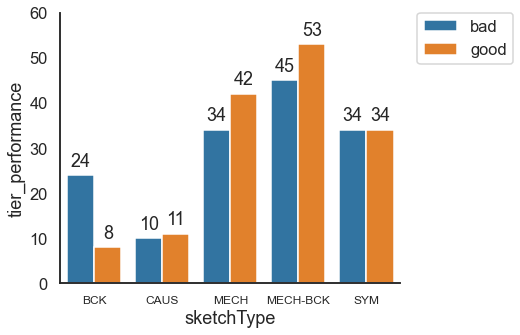

In [31]:
#split by condition
# fig = plt.figure(figsize=(12,10))

g = sns.catplot(data=S4,
                x='sketchType',
                y='tier_performance',
                hue='interventionPerf', 
#                 col='condition', 
                estimator=sum,
                kind='bar', 
                legend=None,
                ci=None)

#plot height
plt.ylim(0, 60)

# add height of bars
for ax in g.axes.flat:
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2,
                height+2,
                '{:}'.format(height.round(3)),
                ha="center")
    ax.tick_params(axis='x', labelsize=12)

plt.tight_layout(rect=[0, 0, 1.2, 1])

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)

#save out
plt.savefig('causaldraw_intervention_sketchType.pdf', format='pdf', dpi=300, bbox_inches = "tight")

In [192]:
11.5+4.5+7+7+16+22+21+28+18.5+15.5

151.0

In [32]:
24+8+10+11+34+42+45+53+34+34

295

In [39]:
S4

,condition,sketchType,interventionPerf,tier_performance
0,depictive,BCK,bad,20
1,explanatory,BCK,bad,4
2,depictive,BCK,good,6
3,explanatory,BCK,good,2
4,explanatory,CAUS,bad,10
5,depictive,CAUS,good,1
6,explanatory,CAUS,good,10
7,depictive,MECH,bad,16
8,explanatory,MECH,bad,18
9,depictive,MECH,good,31


In [34]:
sketchType_df = S4.groupby(['sketchType','interventionPerf'])['tier_performance'].sum().reset_index().reset_index()
# sketchType_df['index_'] = sketchType_df['index'].map(str) + '_' + sketchType_df['sketchType'].map(str)
# sketchType_df = sketchType_df.pivot_table(index='index_', columns='interventionPerf', values='tier_performance', aggfunc='sum').reset_index()
# sketchType_df['sketchType'] = sketchType_df['index_'].apply(lambda x: x.split('_')[1])
# ST = sketchType_df.groupby('sketchType').sum().reset_index()

In [37]:
sketchType_df

,index,sketchType,interventionPerf,tier_performance
0,0,BCK,bad,24
1,1,BCK,good,8
2,2,CAUS,bad,10
3,3,CAUS,good,11
4,4,MECH,bad,34
5,5,MECH,good,42
6,6,MECH-BCK,bad,45
7,7,MECH-BCK,good,53
8,8,SYM,bad,34
9,9,SYM,good,34


In [41]:
# ST.to_csv('sketchTypes_5clusters.csv',index=False)
S4.to_csv('sketchTypes.csv',index=False)

In [ ]:
# (19+7+1+16+31+30+39+1+4)+(4+2+7+13+16+13+12+17+36+27)

In [50]:
background_biased = S3.loc[S3['sketchType'] == 'BCK']
background_biased.to_csv('background_test.csv',index=False)

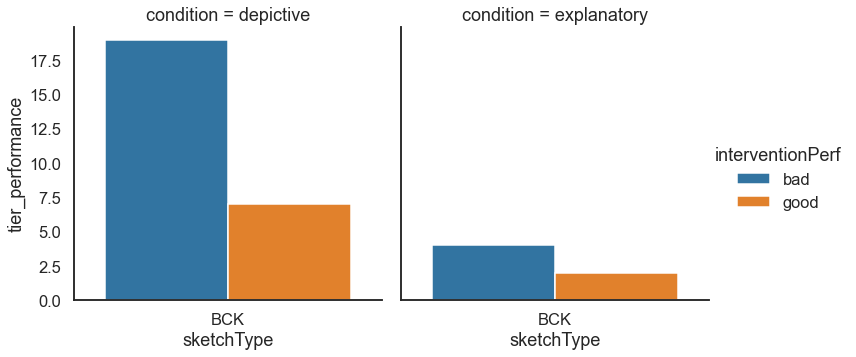

In [47]:
g = sns.catplot(data=background_biased,
                x='sketchType',
                y='tier_performance',
                hue='interventionPerf', 
                col='condition', 
                kind='bar')

In [ ]:
## calculate median and categorize sketches as high or low tier
tier_conditions = [
    (combined['intervention_corrAns'] > combined['intervention_corrAns'].median()), 
    (combined['intervention_corrAns'] < combined['intervention_corrAns'].median())
    ]

## name tiers
# 1 = high performance, 0 = low performance
tier_values = [
    1, 
    0
    ]

## apply to dataframe
combined['tier_performance'] = np.select(tier_conditions, tier_values)

In [ ]:
# combined.groupby('sketch_type').mean()['tier_performance']

In [ ]:
print(combined.groupby(['sketch_type', 'condition'])[['tier_performance', 'propSymbol']].mean().reset_index())

c = combined.groupby(['sketch_type', 'condition'])[['tier_performance', 'propSymbol']].mean().reset_index()
g = sns.barplot(data=c.loc[c['condition'] == 'explanatory'], 
            x='sketch_type',
            y='tier_performance', 
            )

#labels
l = plt.xlabel('sketch type')
m = plt.ylabel('tiered performance')

#plot height
plt.ylim(0, 1)

#add height of bars -- comment this out when exporting fig
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2,
            height+.1,
            '{:}'.format(height.round(2)),
            ha="center") 


#plot prettiness settings
plt.tight_layout(rect=[0, 0, 2, 1])
g.tick_params(axis='x', labelsize=15, rotation=20)

In [ ]:
g = sns.barplot(data=c.loc[c['condition'] == 'depictive'], 
            x='sketch_type',
            y='tier_performance', 
            )

#labels
l = plt.xlabel('sketch type')
m = plt.ylabel('tiered performance')

#plot height
plt.ylim(0, 1)

#add height of bars -- comment this out when exporting fig
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2,
            height+.1,
            '{:}'.format(height.round(2)),
            ha="center") 


#plot prettiness settings
plt.tight_layout(rect=[0, 0, 2, 1])
g.tick_params(axis='x', labelsize=15, rotation=20)

### Messy code: attempt to make 7 (sketch_type) x 2 (tier_performance) contingency table

In [ ]:
expUnit = 'sketchID'
xvar = 'sketch_type'
yvar = 'tier_performance'
num_xbins = 7
num_ybins = 2
render_heatmap = True
fig_height = 8
fig_width = 8
normed=True

xvarbin = '{}_bin'.format(xvar)
yvarbin = '{}_bin'.format(yvar)

xlabels = np.arange(num_xbins)
ylabels = np.arange(num_ybins)

## collapse raw dataframe (num_observations x num_attributes) to sketch-level dataframe (num_sketches x num_attributes)
agg_df = combined.groupby([expUnit, xvar])[[yvar]].mean().reset_index(drop=False)

## get quantile assignments 
# x_assignments = pd.qcut(agg_df[xvar], num_xbins, labels=xlabels, retbins = False)
# y_assignments = pd.qcut(agg_df[yvar], num_ybins, labels=ylabels, retbins = False)
y_assignments = pd.cut(agg_df[yvar], num_ybins, labels=False)

# ## sanity checks (these should all reflect the number of sampled units, e.g., sketchIDs)
# assert len(y_assignments)==agg_df.shape[0]
# assert len(x_assignments)==combined[expUnit].nunique()

# ## now add bin assignments to this dataframe
agg_df = agg_df.assign(xbin = x_assignments, ybin = y_assignments)
XXX = agg_df.assign(xbin = combined['sketch_type'], ybin = y_assignments)

# print(XXX)

agg_df.rename(columns={'xbin':'{}_bin'.format(xvar), 'ybin':'{}_bin'.format(yvar)}, inplace=True)

# ## init heatmap with zeros
mat = np.zeros((num_ybins, num_xbins))

# ## go through each row of the sketch dataframe and increment the corresponding cell by one
for i,d in agg_df.iterrows():
    row_index = d[yvarbin]
    col_index = d[xvarbin]
    mat[row_index, col_index] += 1

# print(agg_df)
    
## get proportions instead of counts    
mat_normed = mat / agg_df.shape[0]

## define output var
output = mat_normed if normed else mat

if render_heatmap:
    ## generate heatmap
    plt.figure(figsize=(fig_width, fig_height))
    sns.heatmap(output, annot=True, cmap='viridis', square=True, cbar_kws={'shrink':0.8})  
    plt.xlabel(xvarbin)
    plt.ylabel(yvarbin)
output = mat_normed if normed else mat


In [ ]:
expUnit = 'sketchID'
xvar = 'rt_annotationToKeyResponse'
yvar = 'corrAns'
num_xbins = 7
num_ybins = 2
render_heatmap = True
fig_height = 8
fig_width = 8
normed=True

xvarbin = '{}_bin'.format(xvar)
yvarbin = '{}_bin'.format(yvar)

xlabels = np.arange(num_xbins)
ylabels = np.arange(num_ybins)

## collapse raw dataframe (num_observations x num_attributes) to sketch-level dataframe (num_sketches x num_attributes)
agg_df = df.groupby(expUnit)[[xvar, yvar]].mean().reset_index(drop=False)

# get quantile assignments 
x_assignments = pd.qcut(agg_df[xvar], num_xbins, labels=xlabels, retbins = False)
y_assignments = pd.qcut(agg_df[yvar], num_ybins, labels=ylabels, retbins = False)
print(y_assignments)
## sanity checks (these should all reflect the number of sampled units, e.g., sketchIDs)
assert len(y_assignments)==agg_df.shape[0]
assert len(x_assignments)==df[expUnit].nunique()

## now add bin assignments to this dataframe
agg_df = agg_df.assign(xbin = x_assignments, ybin = y_assignments)
agg_df.rename(columns={'xbin':'{}_bin'.format(xvar), 'ybin':'{}_bin'.format(yvar)}, inplace=True)

## init heatmap with zeros
mat = np.zeros((num_ybins, num_xbins))

## go through each row of the sketch dataframe and increment the corresponding cell by one
for i,d in agg_df.iterrows():
    row_index = d[yvarbin]
    col_index = d[xvarbin]
    mat[row_index, col_index] += 1

## get proportions instead of counts    
mat_normed = mat / agg_df.shape[0]

## define output var
output = mat_normed if normed else mat

if render_heatmap:
    # generate heatmap
    plt.figure(figsize=(fig_width, fig_height))
    sns.heatmap(output, annot=True, cmap='viridis', square=True, cbar_kws={'shrink':0.8})  
    plt.xlabel(xvarbin)
    plt.ylabel(yvarbin)

In [ ]:
### TODO: split by condition^
## chi-sq for counts of sketch_type by condition
# is distribution diff between condition

# 7x2 contingency table (sketch_type x tier_performance) 
#  — are the rows and columns independent? / is deviation from all mean proportion fo all sketch_type, does it very substantially across all 7 classes 
# (maybe leave out functional_only) // most interesting is ALL, causal_only, causal_structural, mechanical_only to compare against functional_only, functional_structural, structural_only


## then how much does intervention_corrAns or maybe tier_performance vary among sketch_types by condition

# go back to RStudio?

## across diff sketch_type classes, how much variance is explained by condition? 







### what about how symbols are being used?

In [ ]:
## grab orig annotation data (note that this is the same dataset grabbed for the preprocessing used for the 'combined' dataset)
# annots = pd.read_csv('/Users/hollyhuey/causaldraw_annotations/results/csv/causaldraw_annotation_final_data.csv')

annots = pd.read_csv('/Users/hollyhuey/causaldraw_intervention/identification/results/csv/causaldraw_annotation_raw.csv')

## deborkify
if 'Unnamed: 0' in annots.columns:
    annots.drop(labels=['Unnamed: 0'], inplace=True, axis=1)

In [ ]:
## subset symbols
syms = annots.loc[annots['roi_labelName'] == 'symbols']

## reset index so that follow two dataframes match
syms = syms.reset_index(drop=True)
convert_toArray = pd.Series([s.strip("']['").split("', '") for s in syms['roi_symLabelID']])

## check that conversion to array works
# convert_toArray[1542][0]
# syms[1542][0]

## add convert_toArray to syms
syms['roi_symLabelID_array'] = convert_toArray

## first save original arrays into new column before replacing values
syms['roi_symLabelID_origArray'] = syms['roi_symLabelID_array'].copy()

In [ ]:
z = annots.loc[annots['sketchID'] == 'pulleys_1.2659-dd1b5c39-13c7-4a69-836f-03279f53939d']
z

In [ ]:
x = syms.loc[syms['sketchID'] == 'pulleys_1.2659-dd1b5c39-13c7-4a69-836f-03279f53939d']
x

In [ ]:
y = combined.loc[combined['sketchID'] == 'pulleys_1.2659-dd1b5c39-13c7-4a69-836f-03279f53939d']
y

In [ ]:
## this is not great coding...

## convert categorize each elements as causal, functional, background, or light
## first explode
s = syms.explode('roi_symLabelID_array')

## then use np.select to replace values
# conditional conversion for both gear machines
gear_func_1 = ((s['roi_symLabelID_array'] == '1 gear') | (s['roi_symLabelID_array'] == '2 gear'))
gears_1f = gear_func_1&s['toy_id'].eq('gears_1')
s['roi_symLabelID_array'] = np.select([gears_1f],['functional'],default = s.roi_symLabelID_array.values )

gear_func_2 = ((s['roi_symLabelID_array'] == '1 gear') | (s['roi_symLabelID_array'] == '2 gear') | (s['roi_symLabelID_array'] == '3 gear'))
gears_2f = gear_func_2&s['toy_id'].eq('gears_2')
s['roi_symLabelID_array'] = np.select([gears_2f],['functional'],default = s.roi_symLabelID_array.values )

gear_caus_1 = ((s['roi_symLabelID_array'] == '3 gear') | (s['roi_symLabelID_array'] == '4 gear'))
gears_1c = gear_caus_1&s['toy_id'].eq('gears_1')
s['roi_symLabelID_array'] = np.select([gears_1c],['causal'],default = s.roi_symLabelID_array.values )

gear_caus_2 = ((s['roi_symLabelID_array'] == '4 gear') | (s['roi_symLabelID_array'] == '5 gear') | (s['roi_symLabelID_array'] == '6 gear'))
gears_2c = gear_caus_2&s['toy_id'].eq('gears_2')
s['roi_symLabelID_array'] = np.select([gears_2c],['causal'],default = s.roi_symLabelID_array.values )

gear_back_1 = ((s['roi_symLabelID_array'] == '5 background'))
gears_1b = gear_back_1&s['toy_id'].eq('gears_1')
s['roi_symLabelID_array'] = np.select([gears_1b],['background'],default = s.roi_symLabelID_array.values )

gear_back_2 = ((s['roi_symLabelID_array'] == '7 background'))
gears_2b = gear_back_2&s['toy_id'].eq('gears_2')
s['roi_symLabelID_array'] = np.select([gears_2b],['background'],default = s.roi_symLabelID_array.values )

gear_light_1 = ((s['roi_symLabelID_array'] == '6 light'))
gears_1l = gear_light_1&s['toy_id'].eq('gears_1')
s['roi_symLabelID_array'] = np.select([gears_1l],['light'],default = s.roi_symLabelID_array.values )

gear_light_2 = ((s['roi_symLabelID_array'] == '8 light'))
gears_2l = gear_light_2&s['toy_id'].eq('gears_2')
s['roi_symLabelID_array'] = np.select([gears_2l],['light'],default = s.roi_symLabelID_array.values )

## for both lever machines
lever_func = ((s['roi_symLabelID_array'] == '1 weight') | (s['roi_symLabelID_array'] == '3 weight') | (s['roi_symLabelID_array'] == '2 beam'))
levers_1f = lever_func&s['toy_id'].eq('levers_1')
levers_2f = lever_func&s['toy_id'].eq('levers_2')
s['roi_symLabelID_array'] = np.select([levers_1f,levers_2f],['functional','functional'],default = s.roi_symLabelID_array.values )

lever_caus = ((s['roi_symLabelID_array'] == '4 weight') | (s['roi_symLabelID_array'] == '6 weight') | (s['roi_symLabelID_array'] == '5 beam'))
levers_1c = lever_caus&s['toy_id'].eq('levers_1')
levers_2c = lever_caus&s['toy_id'].eq('levers_2')
s['roi_symLabelID_array'] = np.select([levers_1c,levers_2c],['causal','causal'],default = s.roi_symLabelID_array.values )

lever_back = ((s['roi_symLabelID_array'] == '7 background'))
lever_1b = lever_back&s['toy_id'].eq('levers_1')
lever_2b = lever_back&s['toy_id'].eq('levers_2')
s['roi_symLabelID_array'] = np.select([lever_1b,lever_2b],['background','background'],default = s.roi_symLabelID_array.values )

lever_light = ((s['roi_symLabelID_array'] == '8 light'))
lever_1l = lever_light&s['toy_id'].eq('levers_1')
lever_2l = lever_light&s['toy_id'].eq('levers_2')
s['roi_symLabelID_array'] = np.select([lever_1l,lever_2l],['light','light'],default = s.roi_symLabelID_array.values )

## for both pulley machines
pulley_func_1 = ((s['roi_symLabelID_array'] == '2 wheel') | (s['roi_symLabelID_array'] == '3 wheel') | (s['roi_symLabelID_array'] == '6 string'))
pulley_1f = pulley_func_1&s['toy_id'].eq('pulleys_1')
s['roi_symLabelID_array'] = np.select([pulley_1f],['functional'],default = s.roi_symLabelID_array.values )

pulley_func_2 = ((s['roi_symLabelID_array'] == '3 wheel') | (s['roi_symLabelID_array'] == '4 wheel') | (s['roi_symLabelID_array'] == '6 string'))
pulley_2f = pulley_func_2&s['toy_id'].eq('pulleys_2')
s['roi_symLabelID_array'] = np.select([pulley_2f],['functional'],default = s.roi_symLabelID_array.values )

pulley_caus_1 = ((s['roi_symLabelID_array'] == '1 wheel') | (s['roi_symLabelID_array'] == '4 wheel') | (s['roi_symLabelID_array'] == '5 string'))
pulley_1c = pulley_caus_1&s['toy_id'].eq('pulleys_1')
s['roi_symLabelID_array'] = np.select([pulley_1c],['causal'],default = s.roi_symLabelID_array.values )

pulley_caus_2 = ((s['roi_symLabelID_array'] == '1 wheel') | (s['roi_symLabelID_array'] == '2 wheel') | (s['roi_symLabelID_array'] == '5 string'))
pulley_2c = pulley_caus_2&s['toy_id'].eq('pulleys_2')
s['roi_symLabelID_array'] = np.select([pulley_2c],['causal'],default = s.roi_symLabelID_array.values )

pulley_back = ((s['roi_symLabelID_array'] == '7 background'))
pulley_1b = pulley_back&s['toy_id'].eq('pulleys_1')
pulley_2b = pulley_back&s['toy_id'].eq('pulleys_2')
s['roi_symLabelID_array'] = np.select([pulley_1b,pulley_2b],['background','background'],default = s.roi_symLabelID_array.values )

pulley_light = ((s['roi_symLabelID_array'] == '8 light'))
pulley_1l = pulley_light&s['toy_id'].eq('pulleys_1')
pulley_2l = pulley_light&s['toy_id'].eq('pulleys_2')
s['roi_symLabelID_array'] = np.select([pulley_1l,pulley_2l],['light','light'],default = s.roi_symLabelID_array.values )

#combined all replaced data together
syms['roi_symLabelID_array'] = s.groupby(level=0)['roi_symLabelID_array'].agg(list)

## visual check
syms['roi_symLabelID_array'][1542]

In [ ]:
syms_subset = syms[['condition', 'toy_id', 'gameID', 'strokeType', 'sketchID',
                    'roi_symLabelID', 'roi_symLabelID_array', 'roi_symLabelID_origArray', 'strokeIndex']].reset_index()

In [ ]:
## visual check if conversion from button label to strokeType worked
# syms_subset.loc[syms_subset['toy_id'] == 'pulleys_2']

In [ ]:
## add counter of elements within 'roi_symLabelID_array'
syms_subset['array_len'] = syms_subset.roi_symLabelID_array.apply(lambda x: len(x))

In [ ]:
h = plt.hist(syms_subset['array_len'])
plt.xlabel('number elements that 1 symbol stroke refers to')
plt.ylabel('counts')

Counter(Counter(syms_subset['array_len']))

### extract symbols that refer to 1 element
for the purposes of this analysis, i think we might want to start by being pretty strict about those cases. what proportion of symbols are referring to just one thing vs. >1? to start out, maybe we could just consider just those symbols that are referring to exactly one thing, and of just those symbols that refer to exactly one thing, what is the distribution over what they refer to

does that help / make sense? then as a second/subsequent cut, we can consider those cases where the symbols refer to > 1 thing to see what's going on with them

In [ ]:
## extract symbols that refer to 1 element
syms_subset_1 = syms_subset.loc[syms_subset['array_len'] == 1]

## copy to a general dataset so that the below code can generalize to other syms_subset_N
df = syms_subset_1.copy()

#convert 'roi_symLabelID_array' as list into string
df['roi_symLabelID_array_string'] = [','.join(map(str, l)) for l in df['roi_symLabelID_array']]
df['roi_symLabelID_type'] = df['roi_symLabelID_array_string'].copy() 
df.drop(labels=['roi_symLabelID_array', 'roi_symLabelID_array_string', 'roi_symLabelID_origArray'],inplace=True, axis=1)

In [ ]:
df.head()

In [ ]:
## do we want only symbols referring to causal and functional elements 
## if so, set reallyRun = True

reallyRun = True

if reallyRun: 
    print('Dataset does not contain background and light strokes')
    
    df = df.loc[df['roi_symLabelID_type'] != 'background']
    df = df.loc[df['roi_symLabelID_type'] != 'light']
    
    ## get counts of each type of annotation
    E = df.groupby(['sketchID', 'condition'])['roi_symLabelID_type'].value_counts().reset_index(name='type_counts')
    
    ## pivot long to wide, so one column per each annotation type
    F = E.pivot(index=['sketchID', 'condition'], columns='roi_symLabelID_type', values='type_counts').reset_index()

    ## add total strokes column
    F = F.assign(totalStrokes = F.apply(lambda x: np.nansum([x['causal'],x['functional']]),axis=1))

    ## replace NaNs with zeros
    F = F.fillna(value=0)

    ## rename columns
    F = F.rename({'causal':'numCausal','functional':'numFunctional'}, axis=1)

    ## add proportion columns
    F = F.assign(sym_propCausal = F.apply(lambda x: x['numCausal']/x['totalStrokes'],axis=1))
    F = F.assign(sym_propFunctional = F.apply(lambda x: x['numFunctional']/x['totalStrokes'],axis=1))

    F_subset = F[['sketchID', 'condition', 'sym_propCausal', 'sym_propFunctional']].reset_index()
    
    ## add symbol data to combined data
    combined_sym = combined.merge(F_subset, on=['sketchID', 'condition']).reset_index(drop=True)

    ## allocation of symbols to elements WHEN symbols were used, by sketch_type
    print(combined_sym.groupby(['sketch_type', 'condition'])[['sym_propCausal', 'sym_propFunctional']].mean().reset_index())

## do we want a fine-grain analysis of causal, functional, background, and light? 
## if so, set reallyRun = False
else:
    print('Dataset contains background and light strokes')
    
    ## get counts of each type of annotation
    E = df.groupby(['sketchID', 'condition'])['roi_symLabelID_type'].value_counts().reset_index(name='type_counts')

    ## pivot long to wide, so one column per each annotation type
    F = E.pivot(index=['sketchID', 'condition'], columns='roi_symLabelID_type', values='type_counts').reset_index()

    ## add total strokes column
    F = F.assign(totalStrokes = F.apply(lambda x: np.nansum([x['background'],x['causal'],x['functional'],x['light']]),axis=1))

    ## replace NaNs with zeros
    F = F.fillna(value=0)

    ## rename columns
    F = F.rename({'background':'numBackground','causal':'numCausal','functional':'numFunctional',
              'light':'numLight'}, axis=1)

    ## add proportion columns
    F = F.assign(sym_propCausal = F.apply(lambda x: x['numCausal']/x['totalStrokes'],axis=1))
    F = F.assign(sym_propFunctional = F.apply(lambda x: x['numFunctional']/x['totalStrokes'],axis=1))
    F = F.assign(sym_propLight = F.apply(lambda x: x['numLight']/x['totalStrokes'],axis=1))
    F = F.assign(sym_propBackground = F.apply(lambda x: x['numBackground']/x['totalStrokes'],axis=1))

    F_subset = F[['sketchID', 'condition', 'sym_propCausal', 'sym_propFunctional', 'sym_propLight', 'sym_propBackground']].reset_index()
    
    ## add symbol data to combined data
    combined_sym = combined.merge(F_subset, on=['sketchID', 'condition']).reset_index(drop=True)

    ## allocation of symbols to elements WHEN symbols were used, by sketch_type
    print(combined_sym.groupby(['sketch_type', 'condition'])[['sym_propCausal', 'sym_propFunctional', 'sym_propBackground', 'sym_propLight']].mean().reset_index())
    
## visually check that rows have expanded correctly
# syms_subset.loc[syms_subset['index'] == 1542]
# expanded_syms_subset.loc[expanded_syms_subset['index'] == 1542]

In [ ]:
x = combined_sym.loc[combined_sym['sketch_type'] == 'causal_only']
x.loc[78]['sketchID']

In [ ]:
## only visualize caual and functional?
## if so, set reallyRun = True

reallyRun = True

#cleanup label names before plotting
if reallyRun:
    c_sym = combined_sym.groupby(['sketch_type', 'condition'])[['sym_propCausal', 'sym_propFunctional']].mean().reset_index()
    c_long = pd.melt(c_sym, id_vars=['sketch_type', 'condition'], value_vars=['sym_propCausal', 'sym_propFunctional'])
    c_long = c_long.replace({'variable': {'sym_propCausal': 'causal', 
                                          'sym_propFunctional': 'functional', 
                                        }})
    print('Dataset includes background and light strokes')

else:  
    c_sym = combined_sym.groupby(['sketch_type', 'condition'])[['sym_propCausal', 'sym_propFunctional', 'sym_propBackground', 'sym_propLight']].mean().reset_index()
    c_long = pd.melt(c_sym, id_vars=['sketch_type', 'condition'], value_vars=['sym_propCausal', 'sym_propFunctional', 'sym_propBackground', 'sym_propLight'])
    c_long = c_long.replace({'variable': {'sym_propCausal': 'causal', 
                                          'sym_propFunctional': 'functional', 
                                          'sym_propBackground': 'background',
                                          'sym_propLight': 'light'
                                        }})
    print('Dataset does not include background and light strokes')


g = sns.barplot(data= c_long, #c_long.loc[c_long['condition'] == 'explanatory'],
            x='sketch_type',
            y='value', 
            hue='variable', 
            ci=None
            )

#labels
plt.title('Proportion of Symbol by Sketch Type')
l = plt.xlabel('sketch type')
m = plt.ylabel('proportion')

#plot height
plt.ylim(0, 1)

#add height of bars -- comment this out when exporting fig
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2,
            height+.1,
            '{:}'.format(height.round(2)),
            ha="center") 

#plot prettiness settings
plt.tight_layout(rect=[0, 0, 3.5, 1])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

g.tick_params(axis='x', labelsize=15, rotation=20)

In [ ]:
c = combined.groupby('sketch_type')[['tier_performance', 'propSymbol']].mean().reset_index()

g = sns.barplot(data=c, 
            x='sketch_type',
            y='tier_performance', 
            )


#labels
plt.title('Sketch Type Performance')
l = plt.xlabel('sketch type')
m = plt.ylabel('tiered performance')

#plot height
plt.ylim(0, 1)

#add height of bars -- comment this out when exporting fig
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2,
            height+.1,
            '{:}'.format(height.round(2)),
            ha="center") 


#plot prettiness settings
plt.tight_layout(rect=[0, 0, 2, 1])
g.tick_params(axis='x', labelsize=15, rotation=20)

### Beware! sandbox scraps below 

In [ ]:
## expand so that each row has one 
## https://stackoverflow.com/questions/42012152/unstack-a-pandas-column-containing-lists-into-multiple-rows
# lst_col = 'roi_symLabelID_array'
# expanded_syms_subset = pd.DataFrame({col:np.repeat(syms_subset[col].values, syms_subset[lst_col].str.len()) 
#               for col in syms_subset.columns.difference([lst_col])
#              }).assign(**{lst_col:np.concatenate(syms_subset[lst_col].values)})[syms_subset.columns.tolist()]

reallyRun = False
if reallyRun: 
    print('Dataset does not contain background and light strokes')
    
    expanded_syms_subset = expanded_syms_subset.loc[expanded_syms_subset['roi_symLabelID_array'] != 'background']
    expanded_syms_subset = expanded_syms_subset.loc[expanded_syms_subset['roi_symLabelID_array'] != 'light']
    
    ## get counts of each type of annotation
    E = expanded_syms_subset.groupby(['sketchID', 'condition'])['roi_symLabelID_array'].value_counts().reset_index(name='type_counts')
    
    ## pivot long to wide, so one column per each annotation type
    F = E.pivot(index=['sketchID', 'condition'], columns='roi_symLabelID_array', values='type_counts').reset_index()

    ## add total strokes column
    F = F.assign(totalStrokes = F.apply(lambda x: np.nansum([x['causal'],x['functional']]),axis=1))

    ## replace NaNs with zeros
    F = F.fillna(value=0)

    ## rename columns
    F = F.rename({'causal':'numCausal','functional':'numFunctional'}, axis=1)

    ## add proportion columns
    F = F.assign(sym_propCausal = F.apply(lambda x: x['numCausal']/x['totalStrokes'],axis=1))
    F = F.assign(sym_propFunctional = F.apply(lambda x: x['numFunctional']/x['totalStrokes'],axis=1))

    F_subset = F[['sketchID', 'condition', 'sym_propCausal', 'sym_propFunctional']].reset_index()
    
    ## add symbol data to combined data
    combined_sym = combined.merge(F_subset, on=['sketchID', 'condition']).reset_index(drop=True)

    ## allocation of symbols to elements WHEN symbols were used, by sketch_type
#     print(combined_sym.groupby(['sketch_type', 'condition'])[['sym_propCausal', 'sym_propFunctional']].mean().reset_index())

else:
    print('Dataset contains background and light strokes')
    
    ## get counts of each type of annotation
    E = expanded_syms_subset.groupby(['sketchID', 'condition'])['roi_symLabelID_array'].value_counts().reset_index(name='type_counts')

    ## pivot long to wide, so one column per each annotation type
    F = E.pivot(index=['sketchID', 'condition'], columns='roi_symLabelID_array', values='type_counts').reset_index()

    ## add total strokes column
    F = F.assign(totalStrokes = F.apply(lambda x: np.nansum([x['background'],x['causal'],x['functional'],x['light']]),axis=1))

    ## replace NaNs with zeros
    F = F.fillna(value=0)

    ## rename columns
    F = F.rename({'background':'numBackground','causal':'numCausal','functional':'numFunctional',
              'light':'numLight'}, axis=1)

    ## add proportion columns
    F = F.assign(sym_propCausal = F.apply(lambda x: x['numCausal']/x['totalStrokes'],axis=1))
    F = F.assign(sym_propFunctional = F.apply(lambda x: x['numFunctional']/x['totalStrokes'],axis=1))
    F = F.assign(sym_propLight = F.apply(lambda x: x['numLight']/x['totalStrokes'],axis=1))
    F = F.assign(sym_propBackground = F.apply(lambda x: x['numBackground']/x['totalStrokes'],axis=1))

    F_subset = F[['sketchID', 'condition', 'sym_propCausal', 'sym_propFunctional', 'sym_propLight', 'sym_propBackground']].reset_index()
    
    ## add symbol data to combined data
    combined_sym = combined.merge(F_subset, on=['sketchID', 'condition']).reset_index(drop=True)

    ## allocation of symbols to elements WHEN symbols were used, by sketch_type
#     print(combined_sym.groupby(['sketch_type', 'condition'])[['sym_propCausal', 'sym_propFunctional', 'sym_propBackground', 'sym_propLight']].mean().reset_index())
    
## visually check that rows have expanded correctly
# syms_subset.loc[syms_subset['index'] == 1542]
# expanded_syms_subset.loc[expanded_syms_subset['index'] == 1542]

In [ ]:
## expand dataframe so that every row only has 1 roi_symLabelID_array (not an array anymore)
lst_col = 'roi_symLabelID_array'
expanded_syms_subset = pd.DataFrame({col:np.repeat(syms_subset[col].values, syms_subset[lst_col].str.len()) 
              for col in syms_subset.columns.difference([lst_col])
             }).assign(**{lst_col:np.concatenate(syms_subset[lst_col].values)})[syms_subset.columns.tolist()]

## get counts of each type of annotation
e = expanded_syms_subset.groupby(['sketchID', 'strokeIndex'])['roi_symLabelID_array'].value_counts().reset_index(name='type_counts')

e = e.reset_index()

## get the most commonly assigned roi_symLabelID_array 
m = e.groupby(['sketchID','strokeIndex']).apply(lambda x: x[x['type_counts']==x.type_counts.max()]['roi_symLabelID_array'])

## just pull out these most common label names
n = m.reset_index(drop=False).drop(labels='level_2',axis=1)

## get counts of each type of stroke
p = n.groupby('sketchID')['roi_symLabelID_array'].value_counts().reset_index(name='counts')

## pivot long to wide, so a column for each stroke type
q = p.pivot(index='sketchID', columns='roi_symLabelID_array', values='counts').reset_index()



## add total strokes column
q = q.assign(totalStrokes = q.apply(lambda x: np.nansum([x['background'],x['causal'],x['functional'],x['light']]),axis=1))

## replace NaNs with zeros
q = q.fillna(value=0)

## rename columns
q = q.rename({'background':'numBackground','causal':'numCausal','functional':'numFunctional',
          'light':'numLight'}, axis=1)

## add proportion columns
q = q.assign(sym_propCausal = q.apply(lambda x: x['numCausal']/x['totalStrokes'],axis=1))
q = q.assign(sym_propFunctional = q.apply(lambda x: x['numFunctional']/x['totalStrokes'],axis=1))
q = q.assign(sym_propLight = q.apply(lambda x: x['numLight']/x['totalStrokes'],axis=1))
q = q.assign(sym_propBackground = q.apply(lambda x: x['numBackground']/x['totalStrokes'],axis=1))

q_subset = q[['sketchID', 'sym_propCausal', 'sym_propFunctional', 'sym_propLight', 'sym_propBackground']].reset_index()

## add symbol data to combined data
CCC = combined.merge(p_subset, on=['sketchID']).reset_index(drop=True)

In [ ]:
z = CCC.loc[CCC['sketch_type'] == 'causal_only']
z

In [ ]:
## expand dataframe so that every row only has 1 roi_symLabelID_array (not an array anymore)
lst_col = 'roi_symLabelID_array'
expanded_syms_subset = pd.DataFrame({col:np.repeat(syms_subset[col].values, syms_subset[lst_col].str.len()) 
              for col in syms_subset.columns.difference([lst_col])
             }).assign(**{lst_col:np.concatenate(syms_subset[lst_col].values)})[syms_subset.columns.tolist()]

z = expanded_syms_subset.loc[expanded_syms_subset['sketchID'] == 'gears_1.5369-de50eae9-8b3d-44d0-89c1-b279c4fea591']
z

In [ ]:
Z = p.loc[p['sketchID'] == 'gears_1.5369-de50eae9-8b3d-44d0-89c1-b279c4fea591']
Z

In [ ]:
w = e.loc[e['sketchID'] == 'gears_1.5369-de50eae9-8b3d-44d0-89c1-b279c4fea591']
w

In [ ]:
Y = syms_subset.loc[syms_subset['sketchID'] == 'gears_1.5369-de50eae9-8b3d-44d0-89c1-b279c4fea591']
Y

In [ ]:
E

In [ ]:
## mean performance and usage of symbols by sketch_type
combined.groupby(['sketch_type', 'condition'])[['tier_performance', 'propSymbol']].mean().reset_index()

In [ ]:
#cleanup label names before plotting
reallyRun = True
if reallyRun:
    c_sym = combined_sym.groupby('sketch_type')[['sym_propCausal', 'sym_propFunctional']].mean().reset_index()
    c_long = pd.melt(c_sym, id_vars='sketch_type', value_vars=['sym_propCausal', 'sym_propFunctional'])
    c_long = c_long.replace({'variable': {'sym_propCausal': 'causal', 
                                          'sym_propFunctional': 'functional', 
                                        }})
    print('Dataset includes background and light strokes')

else:  
    c_sym = combined_sym.groupby('sketch_type')[['sym_propCausal', 'sym_propFunctional', 'sym_propBackground', 'sym_propLight']].mean().reset_index()
    c_long = pd.melt(c_sym, id_vars='sketch_type', value_vars=['sym_propCausal', 'sym_propFunctional', 'sym_propBackground', 'sym_propLight'])
    c_long = c_long.replace({'variable': {'sym_propCausal': 'causal', 
                                          'sym_propFunctional': 'functional', 
                                          'sym_propBackground': 'background',
                                          'sym_propLight': 'light'
                                        }})
    print('Dataset does not include background and light strokes')


g = sns.barplot(data=c_long, 
            x='sketch_type',
            y='value', 
            hue='variable', 
            )

#labels
plt.title('Proportion of Symbol by Sketch Type')
l = plt.xlabel('sketch type')
m = plt.ylabel('proportion')

#plot height
plt.ylim(0, 1)

#add height of bars -- comment this out when exporting fig
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2,
            height+.1,
            '{:}'.format(height.round(2)),
            ha="center") 

#plot prettiness settings
plt.tight_layout(rect=[0, 0, 3.5, 1])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

g.tick_params(axis='x', labelsize=15, rotation=20)

In [ ]:
x = combined_sym.loc[combined_sym['sketch_type'] == 'causal_only']
x

In [ ]:
## check merge dataframes
# what prop symbols annotating causal vs. functional by condition 

In [ ]:
c = combined.groupby('sketch_type')[['tier_performance', 'propSymbol']].mean().reset_index()

g = sns.barplot(data=c, 
            x='sketch_type',
            y='tier_performance', 
            )


#labels
plt.title('Sketch Type Performance')
l = plt.xlabel('sketch type')
m = plt.ylabel('tiered performance')

#plot height
plt.ylim(0, 1)

#add height of bars -- comment this out when exporting fig
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2,
            height+.1,
            '{:}'.format(height.round(2)),
            ha="center") 


#plot prettiness settings
plt.tight_layout(rect=[0, 0, 2, 1])
g.tick_params(axis='x', labelsize=15, rotation=20)

#### TODO note: try normalizing accuracy and RT so that you can compute a non-sketchy combined efficiency score and use that to compare conditions

In [ ]:
# barplot for every toy_id, counting key_press responses
g = sns.catplot(data = df, 
            x = 'key_press',
            hue='key_press',
            col='toy_id',
#             row='condition',
            kind='count',
#             aspect = 1
            )

^note to self
• gears_1: choosing 3 when corrAns is 4 (3 & 4 are causal)
• gears_2: choosing 4 when corrAns is 3 (3 & 4 are causal)
• levers_1: choosing mostly 4 but also 1 when corrAns is 4 (2 & 4 are causal)
• levers_2: choosing mostly 4 but also 2 when corrAns is 2 (2 & 4 are causal)
• pulleys_1: choosing mostly 4 but also 3 when corrAns is 1 (1 & 3 are causal)
• *pulleys_2*: choosing mostly 1 but also 2 when corrAns is 1 (1 & 2 are causal)

In [ ]:
# barplot for every machine what prop of responses
g = sns.catplot(data = df, 
            x = 'causal_roi',
            hue='causal_roi',
            col='toy_id',
            row='condition',
            kind='count',
#             aspect = 1
            )

In [ ]:
df['toy_id'] = df['sketchID'].apply(lambda x: x.split('.')[0])
counts = df.groupby(['toy_id', 'condition'])['causal_roi'].value_counts().reset_index(name='type_counts')
c = counts.groupby(['toy_id', 'condition'])['type_counts'].sum().reset_index(name='total')
c["identifier"] = c["toy_id"] + "_" + c["condition"]
counts["identifier"] = counts["toy_id"] + "_" + counts["condition"]
prop_df = pd.merge(c, counts, on="identifier")
prop_df['prop'] = prop_df['type_counts']/prop_df['total']

g = sns.barplot(data = prop_df, 
            x = 'toy_id_x',
            y = 'prop',
            hue='causal_roi',
#             col='condition_x',
#             kind='bar'
            )

for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2,
            height+.18,
            '{:}'.format(height.round(2)),
            ha="center") 

change_width(g, .18)
plt.tight_layout(rect=[0, 0, 5, 2])

g.tick_params(axis='x', labelsize=50, rotation=30)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [ ]:
#### take max of proportion of modal frequencies per sketches 

In [ ]:
### plot whether sketches that are easier to ID are easier to intervene on
combined = pd.read_csv (r'../results/csv/combined_intervention_identification_2AFC_data.csv')
combined['toy_id'] = combined['sketchID'].apply(lambda x: x.split('.')[0])
combined.head()

In [ ]:
sns.scatterplot(data=combined, 
                x='intervention_corrAns',
                y='identification_corrAns',
               )

bound = 1
plt.plot((0,bound),(0,bound),'k:')

plt.title('Are good ID sketches also good intervention sketches?')
plt.tight_layout()

In [ ]:
#split correct answers of sketches in the ID task into quartiles
combined['ID_quartile'] = pd.cut(combined['identification_corrAns'], bins=4, 
                                     labels=['low', 'low_med', 'high_med', 'high'])

combined['inter_quartile'] = pd.cut(combined['intervention_corrAns'], bins=4, 
                                     labels=['low', 'low_med', 'high_med', 'high'])

combined['ID_quartile2'] = pd.cut(combined_2['identification_corrAns'], bins=2, 
                                     labels=['low', 'high'])

combined['inter_quartile2'] = pd.cut(combined_2['intervention_corrAns'], bins=2, 
                                     labels=['low', 'high'])

In [ ]:
combined['totalAvgScore'] = (combined['intervention_corrAns'] + combined['identification_corrAns'])/2 

#### render sketches as html images

In [ ]:
#prep nav path
causaldraw_dir = '/Users/hollyhuey/causaldraw/analysis/sketches/run1/'
combined['path'] = combined['sketchID'] + '_' + combined['toy_id'] + '_' + combined['condition']
combined['nav'] = '<img src="'+ causaldraw_dir + (combined['path'].apply(lambda x: x.split('.')[1])) + '.png' + '" width="60" >'    
render = combined.copy()

#sort by best to worst intervention sketches
render = render.sort_values(by=['inter_quartile'], ascending=False)

#render out as html file -- open from Finder, not jupyter
pd.set_option('display.max_colwidth', -1)
HTML(render.to_html(escape=False))
render.to_html('render_test.html', escape=False)

#render out only explanations -- open from Finder, not jupyter
render_exp = render[render.condition == 'explanatory']
HTML(render_exp.to_html(escape=False))
render_exp.to_html('render_exp_test.html', escape=False)

In [ ]:
combined['inter_decile'] = pd.cut(combined['intervention_corrAns'], bins=10, 
                                     labels=np.arange(10))
combined['inter_quantile'] = pd.cut(combined['intervention_corrAns'], bins=4, 
                                     labels=np.arange(4))
combined['inter_half'] = pd.cut(combined['intervention_corrAns'], bins=2, 
                                     labels=np.arange(2))

combined['ID_decile'] = pd.cut(combined['identification_corrAns'], bins=10, 
                                     labels=np.arange(10))
combined['ID_quantile'] = pd.cut(combined['identification_corrAns'], bins=4, 
                                     labels=np.arange(4))
combined['ID_half'] = pd.cut(combined['identification_corrAns'], bins=2, 
                                     labels=np.arange(2))

causaldraw_dir = '/Users/hollyhuey/causaldraw/analysis/sketches/run1/'
combined['path'] = combined['sketchID'] + '_' + combined['toy_id'] + '_' + combined['condition']
combined['nav'] = '<img src="'+ causaldraw_dir + (combined['path'].apply(lambda x: x.split('.')[1])) + '.png' + '" width="60" >'    
render = combined.copy()

#sort by best to worst intervention sketches
render = render[render.condition == 'explanatory']
render_d = render.sort_values(by=['inter_decile'], ascending=False)
render_d = render_d.drop(['Unnamed: 0'], axis=1)
render_d = render_d.reset_index(drop=True)

#render out as html file -- open from Finder, not jupyter
pd.set_option('display.max_colwidth', -1)
HTML(render_d.to_html(escape=False))
render_d.to_html('render10_test.html', escape=False)

In [ ]:
#sort by best to worst intervention sketches
render = render[render.condition == 'explanatory']
render_q = render.sort_values(by=['inter_quantile'], ascending=False)
render_q = render_q.drop(['Unnamed: 0'], axis=1)
render_q = render_q.reset_index(drop=True)

#render out as html file -- open from Finder, not jupyter
pd.set_option('display.max_colwidth', -1)
HTML(render_q.to_html(escape=False))
render_q.to_html('render4_test.html', escape=False)

In [ ]:
sns.scatterplot(data=combined, 
                x='intervention_corrAns',
                y='identification_corrAns')

bound = 1
plt.plot((0,bound),(0,bound),'k:')

plt.title('Accuracy')
plt.tight_layout()

In [ ]:
top_exp = combined.copy()
top_exp = top_exp.loc[top_exp['intervention_corrAns'] == 1]

sns.histplot(data=top_exp, x="identification_corrAns")

In [ ]:
long = pd.melt(combined, id_vars=['sketchID', 'identification_corrAns', 'toy_id', 'inter_decile', 'inter_quantile', 'inter_half', 'ID_decile', 'ID_quantile', 'ID_half', 'condition'], value_vars=['propCausal', 'propFunctional', 'propBackground', 'propSymbol'])
long.rename(columns={'variable':'type', 'value': 'proportion'}, inplace=True)

In [ ]:
only_exp = long.loc[long['condition'] == 'explanatory']
only_dep = long.loc[long['condition'] == 'depictive']

In [ ]:
g = sns.catplot(data=only_exp, 
            x='inter_quantile',
            y='proportion',
            hue='type',
            kind='bar'
            )
g._legend.remove()

ax = g.facet_axis(0,0)
for p in ax.patches:
    ax.text(p.get_x() + 0.015, 
            p.get_height() * 1.2, 
            '{0:.2f}'.format(p.get_height()), 
            color='black', rotation='horizontal', size='small')
    
plt.tight_layout(rect=[0, 0, 1.75, 1.5])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [ ]:
sns.catplot(data=combined, 
            x='ID_quartile',
            y='intervention_corrAns',
            kind='bar',  
            col='condition'
           )

plt.tight_layout()

In [ ]:
sns.catplot(data=combined, 
            x='ID_quartile',
            y='propCausal',
            kind='bar',  
            col='condition'
           )

plt.tight_layout()

In [ ]:
sns.catplot(data=combined, 
            x='ID_quartile',
            y='propFunctional',
            kind='bar',  
            col='condition'
           )

plt.tight_layout()

In [ ]:
sns.catplot(data=combined, 
            x='ID_quartile',
            y='propBackground',
            kind='bar',  
            col='condition'
           )

plt.tight_layout()

In [ ]:
sns.catplot(data=combined, 
            x='ID_quartile',
            y='propSymbol',
            kind='bar',  
            col='condition'
           )

plt.tight_layout()

In [ ]:
sns.catplot(data=combined, 
            x='inter_quartile',
            y='propCausal',
            kind='bar',  
            col='condition'
           )

plt.tight_layout()

In [ ]:
sns.catplot(data=combined, 
            x='inter_quartile',
            y='propFunctional',
            kind='bar',  
            col='condition'
           )

plt.tight_layout()

In [ ]:
sns.catplot(data=combined, 
            x='inter_quartile',
            y='propBackground',
            kind='bar',  
            col='condition'
           )

plt.tight_layout()

In [ ]:
sns.catplot(data=combined, 
            x='inter_quartile',
            y='propSymbol',
            kind='bar',  
            col='condition'
           )

plt.tight_layout()

### Response time

In [ ]:
df['rtQuartile'] = pd.cut(df['rt_annotationToKeyResponse'], bins=4, labels=np.arange(4))
sns.catplot(data=df, 
            x='rtQuartile',
            y='corrAns',
            kind='bar',  
            col='condition'
           )

plt.tight_layout()

In [ ]:
sns.ecdfplot(data=df, x="rt_annotationToKeyResponse", hue='condition')